# Workshop 2: Introduction to `Snakemake`, new features update & benchmarking

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa pandas geopandas xarray matplotlib seaborn cartopy snakemake graphviz snakemake-storage-plugin-http pdf2image atlite fiona
```
:::

In [ ]:
# uncomment for running this notebook on Colab
# !pip install pypsa pandas geopandas xarray matplotlib seaborn cartopy snakemake graphviz snakemake-storage-plugin-http pdf2image atlite fiona

In [1]:
# import packages
from IPython.display import Code, SVG, Image, IFrame, display
from pdf2image import convert_from_path
from urllib.request import urlretrieve
from matplotlib.ticker import MultipleLocator
import cartopy.crs as ccrs
import os
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pypsa.plot.maps.static import (
    add_legend_circles,
    add_legend_patches,
    add_legend_lines,
)

pypsa.options.params.statistics.round = 3
pypsa.options.params.statistics.drop_zero = True
pypsa.options.params.statistics.nice_names = False
plt.rcParams["figure.figsize"] = [14, 7]

In [2]:
urls = {
    "data/data_raw.csv": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv",
    "data/open-tyndp.zip": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/open-tyndp.zip",
    "data/network_NT_presolve_highres_2030.nc": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/network_NT_presolve_highres_2030.nc",
}

os.makedirs("data", exist_ok=True)
for name, url in urls.items():
    if os.path.exists(name):
        print(f"File {name} already exists. Skipping download.")
    else:
        print(f"Retrieving {name} from GCP storage.")
        urlretrieve(url, name)
        print(f"File available in {name}.")

to_dir = "data/open-tyndp"
if not os.path.exists(to_dir):
    print(f"Unzipping data/open-tyndp.zip.")
    ! unzip -q -o data/open-tyndp.zip -d data/open-tyndp
print(f"Open-TYNDP available in '{to_dir}'.")

print("Done")

File data/data_raw.csv already exists. Skipping download.
File data/open-tyndp.zip already exists. Skipping download.
File data/network_NT_presolve_highres_2030.nc already exists. Skipping download.
Unzipping data/open-tyndp.zip.
Open-TYNDP available in 'data/open-tyndp'.
Done


# The `Snakemake` tool

![](snakemake_logo.png)

The `Snakemake` workflow management system is a tool to create reproducible and scalable data analyses.
Workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid, and cloud environments, without the need to modify the workflow definition.

Snakemake follows the [GNU Make](https://www.gnu.org/software/make) paradigm: workflows are defined in terms of so-called `rules` that specify how to create a set of output files from a set of input files. Dependencies between the rules are determined automatically, creating a DAG (directed acyclic graph) of jobs that can be automatically parallelized.

:::{note}
Documentation for this package is available at https://snakemake.readthedocs.io/. You can also check out a [slide deck Snakemake Tutorial](https://slides.com/johanneskoester/snakemake-tutorial) by Johannes Köster (2024).

Mölder, F., Jablonski, K.P., Letcher, B., Hall, M.B., Tomkins-Tinch, C.H., Sochat, V., Forster, J., Lee, S., Twardziok, S.O., Kanitz, A., Wilm, A., Holtgrewe, M., Rahmann, S., Nahnsen, S., Köster, J., 2021. Sustainable data analysis with Snakemake. F1000Res 10, 33.
:::


## A minimal Snakemake example

To check out how this looks in practice, we've prepared a minimal Snakemake example workflow that processes some data. The minimal workflow consists of the following rules:
- `retrieve_data`
- `build_data`
- `prepare_network`
- `solve_network`
- `plot_benchmark`
- `all`

These rules are illustrative and mimic the Open-TYNDP structure and nomenclature.

<center>

![](minimal_workflow.png)

</center>

We have already loaded the raw data file used in this minimal example into our working directory.

As you can see, `plot_benchmark` will be called twice with two different filename extensions. For this, we are taking advantage of the concept of wildcards (`ext`). Snakemake will automatically resolve the wildcards using the dependency graph. In this case, the `all` rule takes as input both a `png` and a `pdf` figure which propagates back throughout the workflow.

### The `Snakefile` and `rules`

The rules need to be defined in a so-called `Snakefile` that sits in your current working directory. For our minimal example the `Snakefile` looks like this:

In [3]:
Code(filename="Snakefile", language="Python")

# SPDX-FileCopyrightText: Open Energy Transition gGmbH
#
# SPDX-License-Identifier: MIT

from pathlib import Path

rule all:
    input:
        "data/benchmark.png",
        "data/benchmark.pdf"

rule retrieve_data:
    output:
        "data/data_raw.csv"
    shell:
        "wget -O {output} https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv"

rule build_data:
    input:
        "data/data_raw.csv"
    output:
        "data/data_filtered.csv"
    script:
        "scripts/build_data.py"

rule prepare_network:
    input:
        "data/data_filtered.csv"
    output:
        "data/base_2030.nc"
    script:
        "scripts/prepare_network.py"

rule solve_network:
    input:
        "data/base_2030.nc"
    output:
        "data/base_2030_solved.nc"
    shell:
        "cp {input} {output}"

rule plot_benchmark:
    input:
        "data/base_2030_solved.nc"
    output:
        "data/benchmark.{ext}"
    run:
        Path(output[0]).touch()

You can check out the scripts under `scripts`. You will see that they are simplistic and only serve an illustrative purpose.

You can also observe how the `plot_benchmark` rule is defined to take advantage of the wildcards. This reduces the redundancy in the `Snakefile`. Wildcards are defined between `{ }` in the rule definition.

### Calling a workflow

You can trigger the workflow by specifying a target file, like `data/benchmark.pdf`, or any intermediate file:
```bash
snakemake -call data/benchmark.pdf
```

Alternatively, you can also execute the workflow by calling a rule that produces an intermediate file:
```bash
snakemake -call build_data
```
**NOTE:** You cannot call a rule that includes a wildcard without specifying what the wildcard should be filled with. Otherwise, Snakemake will not know what to propagate back.

Or you can call the common rule `all` which can be used to execute the entire workflow. It takes the final workflow output as its input and thus requires all previous dependent rules to be run as well:
```bash
snakemake -call all
```

Because we defined the `all` rule as first in the `Snakefile`, this rule is assumed to be the default and the following also works:
```bash
snakemake -call
```

A very important feature is the `-n` flag which executes a `dry-run`. It is recommended to always first execute a `dry-run` before the actual execution of a workflow. This simply prints out the DAG of the workflow to investigate without actually executing it.

Let's try this out and investigate the output:

In [4]:
! snakemake -call -n

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-14
host: Mac.home
Building DAG of jobs...
Job stats:
job                count
---------------  -------
all                    1
build_data             1
plot_benchmark         2
prepare_network        1
solve_network          1
total                  6


[Tue Oct 14 15:43:13 2025]
rule build_data:
    input: data/data_raw.csv
    output: data/data_filtered.csv
    jobid: 4
    reason: Missing output files: data/data_filtered.csv
    resources: tmpdir=<TBD>
[Tue Oct 14 15:43:13 2025]
rule prepare_network:
    input: data/data_filtered.csv
    output: data/base_2030.nc
    jobid: 3
    reason: Missing output files: data/base_2030.nc; Input files updated by another job: data/data_filtered.csv
    resources: tmpdir=<TBD>
[Tue Oct 14 15:43:13 2025]
rule solve_network:
    input: data/base_2030.nc
    output: data/base_2030_solved.nc
    jobid: 2
    reason: Missing output files: data/base_2030_solved.nc;

As you can see, the `plot_benchmark` rule will be executed twice due to wildcards.

### Visualizing the `DAG` of a workflow

You can also visualize the DAG of jobs using the `--dag` flag and the Graphviz `dot` command. This will not run the workflow but only create the visualization:

In [5]:
! snakemake -call --dag | sed -n "/digraph/,\$p" | dot -Tpng > dag_minimal.png

Building DAG of jobs...


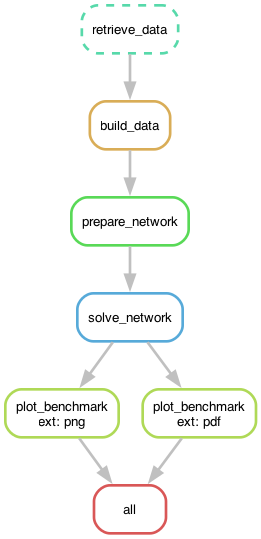

In [6]:
Image("dag_minimal.png")

Rules that need to be executed will be presented as plain lines, while those that have already been executed will be presented as dotted lines. An alternative to the DAG is the `rulegraph`. This graph is typically less crowded as you will only visualize the dependency graph of rules. This representation is leaner than the DAG because rules are not repeated for wildcards.

In [7]:
! snakemake -call all --rulegraph | sed -n "/digraph/,\$p" | dot -Tpng > rulegraph_minimal.png

Building DAG of jobs...


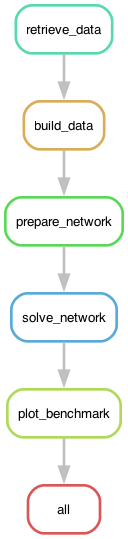

In [8]:
Image("rulegraph_minimal.png")

As you can see, the `plot_benchmark` rule is only represented once.

Alternatively, you can also visualize a `filegraph`, which is similar to the `rulegraph` but includes some information about the inputs and outputs to each of the rules.

In [9]:
! snakemake -call all --filegraph | sed -n "/digraph/,\$p" | dot -Tsvg > filegraph_minimal.svg

Building DAG of jobs...


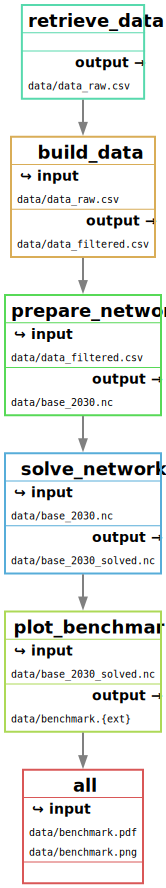

In [10]:
SVG("filegraph_minimal.svg")

## Task 1: Executing a workflow with Snakemake

**a)** For our minimal example, execute a `dry-run` to produce the intermediate file `data/base_2030.nc`.

**b)** Execute the entire workflow and investigate what happens if you try to execute the workflow again.

**c)** Delete the final output file `data/benchmark.pdf` and investigate what happens if you try to execute the workflow again.

**d)** Change a value in the raw input data file `data/data_raw.csv` and save it again, overwriting the original file. Investigate what happens if you try to execute the workflow again.

Hint: You can also just `touch` the file by executing `Path("data/data_raw.csv").touch()`. This will mimic a file edit.

**e)** (Optional) Open the `Snakefile` and add a second rule that processes the file `data_raw_2.csv` using the same script as the `build_data` rule. Add the output of this new rule as a second input to the `prepare_network` rule.

In [11]:
# Your solution a)

In [12]:
# Your solution b)

In [13]:
# Your solution c)

In [14]:
# Your solution d)

In [15]:
# Your solution e)

## Discover Open-TYNDP file structure

We have already retrieved a prebuilt version of the `open-tyndp` GitHub repository into our working directory. This folder contains a run of Open-TYNDP for NT and DE scenarios, with 2030 and 2040 as planning horizons. We removed the atlite cutout from the archive and compressed the archive using `zip -r open-tyndp.zip .`.

The `open-tyndp` repository contains the following structure. Directories of particular interest are marked in bold:

- **benchmarks**: will store Snakemake benchmarks (does not exist initially)
- **config**: configurations used in the study
- cutouts: will store raw weather data cutouts from atlite (does not exist initially)
- **data**: includes input data that is not produced by any Snakemake rule. Various different input files are retrieved from external storage and stored in this directory
- doc: includes all files necessary to build the readthedocs documentation of PyPSA-Eur
- **envs**: includes all the mamba environment specifications to run the workflow
- logs: will store log files (does not exist initially)
- notebooks: includes all the notebooks used for ad-hoc analysis
- report: contains all files necessary to build the report; plots and result files are generated automatically
- **rules**: includes all the Snakemake rules loaded in the Snakefile
- **resources**: will store intermediate results of the workflow which can be picked up again by subsequent rules (does not exist initially)
- **results**: will store the solved PyPSA network data, summary files and output plots (does not exist initially)
- **scripts**: includes all the Python scripts executed by the Snakemake rules to build the model

## Task 2: Explore the folder

**a)** Can you find the TYNDP specific data input files?

**b)** Where can you verify the scenario and planning horizons used to produce the current results?

Hint: Search for `config.tyndp.yaml`.

**c)** Can you find the hydrogen grid map in the output files for the NT scenario in 2040?

Hint: Search for `base_s_all__-h2_network_2040.pdf`.

In [16]:
# Your solution a)

In [17]:
# Your solution b)

In [18]:
# Your solution c)

## Using Snakemake to launch the Open-TYNDP workflow

We now need to change our working directory to the Open-TYNDP directory we previously retrieved.

In [19]:
os.chdir("data/open-tyndp")

Be aware that to run the previous section of this notebook, you will need to restore the default working directory using `os.chdir("../../")`.

Let's check that we are indeed in the new directory now:

In [20]:
os.getcwd()

'/Users/daniel/Desktop/Work/OET/Projects/open-tyndp/code/open-tyndp-workshops/open-tyndp-workshops/data/open-tyndp'

We can now use Snakemake to call some of the rules to produce outputs with the `open-tyndp` PyPSA model. 

We will use the prepared TYNDP configuration file (`config/config.tyndp.yaml`) and schedule a dry-run with `-n` as we only want to investigate the DAG of the workflow:

In [ ]:
! snakemake -call --configfile config/config.tyndp.yaml -n

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-14
host: Mac.home
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


As you can see, there is nothing to be done. However, we can still explore the set of rules defined in the `Snakefile` and the other `.smk` files. First, we can plot the rule graph, then the full DAG.

The corresponding rule graph to this workflow will look like this:

In [ ]:
! snakemake -call --configfile config/config.tyndp.yaml --rulegraph | sed -n "/digraph/,\$p" | dot -Tpng > rulegraph_open_tyndp.png

In [ ]:
Image("rulegraph_open_tyndp.png")

The corresponding DAG to this workflow will look like this:

In [ ]:
! snakemake -call --configfile config/config.tyndp.yaml --dag | sed -n "/digraph/,\$p" | dot -Tpng > dag_open_tyndp.png

In [ ]:
Image("dag_open_tyndp.png")

As you can see, this workflow is much more complex than our minimal example from the beginning. Since we already executed the entire workflow for this demonstration, all the rules are presented as dotted lines in the DAG.

You will also notice that the DAG is much larger than the rule graph. This is because Open-TYNDP leverages wildcards quite extensively to generalize rule definitions and to parallelize tasks.

Nevertheless, the general idea remains the same. We retrieve data which we consequently process, then we prepare the model network and we solve it before we postprocess the results (summary, plotting, benchmarks).

## Triggering a workflow run on Open-TYNDP

Let's now simulate the end of an optimization with the network (`base_s_all___2040.nc`) file being written as the last step.

In [ ]:
Path("results/tyndp/NT/networks/base_s_all___2040.nc").touch()

We can now see that Snakemake triggers all the rules that depend on the solved network. In this case, these are all the postprocessing rules.

In [ ]:
! snakemake -call --configfile config/config.tyndp.yaml -n

:::{note}
Because of the complexity of the workflow, we are not executing this. However, if you are running this notebook on your local machine, you can also use the `conda` package manager to install the `pypsa-eur` environment and run the workflow instead of dry-runs:
```
conda env create --file envs/<YourSystemOS>.lock.yaml
```
:::

# Update on new features

For the purposes of this workshop, we will primarily focus on the 2030 NT scenario and the 2040 DE scenario. Four major features were introduced since our last workshop:
1. Addition of the electricity demand and PECD capacity factors time series,
2. Addition of onshore wind and solar TYNDP technologies (incl. PEMMDB existing capacities and trajectories),
3. Addition of offshore hubs (incl. the offshore topology, all associated technologies, potential constraints and trajectories),
4. Addition of hydrogen import corridors.

The Open-TYNDP data we retrieved contains networks with low time resolution (6H). This is illustrative; however, since we are focusing on time series, we will use another network with hourly resolution. We will import this pre-solved network for NT 2030.

In [ ]:
n_NT_2030h = pypsa.Network("../network_NT_presolve_highres_2030.nc")

## Electricity demand profiles

We can then explore the electricity demand profiles that are attached to the network. Can you remember how to access time-varying attributes of components in PyPSA?

In [ ]:
loads_2030 = n_NT_2030h.loads_t.p_set
loads_2030.head()

Let's plot the electricity demand time series:

In [ ]:
fig, ax = plt.subplots()
loads_2030.div(1e3).plot(
    xlabel="Time",
    ylabel="Load [GW]",
    title="Electricity Load Time Series - NT - 2030",
    grid=True,
    ax=ax,
)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncols=10)
ax.grid(True, linestyle="--");

This is very overwhelming to look at. Let's filter that down a bit...

In [ ]:
# Group country profiles together and select a week
country_mapping = n_NT_2030h.buses.query("carrier=='AC'").country
loads_2030_by_country = (
    n_NT_2030h.loads_t.p_set.T.rename(country_mapping, axis=0)
    .groupby("Load")
    .sum()
    .T.loc["2009-03-01":"2009-03-07", ["FR", "DE", "GB"]]
)

# Create the plot
fig, ax = plt.subplots()
loads_2030_by_country.div(1e3).plot(
    xlabel="Time",
    ylabel="Load [GW]",
    title="Electricity Load Time Series - NT - 2030",
    ax=ax,
)

ax.grid(True, linestyle="--")
ax.legend();

As you might remember, we can also use the **PyPSA Statistics** module that we introduced in the last workshop to interactively visualize these electricity demand inputs from the network. For this to work, we need a solved network.

Let's load our pre-solved networks, so we can use the statistics module to analyze it.

In [ ]:
# Import networks
n_NT_2030 = pypsa.Network("results/tyndp/NT/networks/base_s_all___2030.nc")
n_DE_2040 = pypsa.Network("results/tyndp/DE/networks/base_s_all___2040.nc")

# Fix missing colors
n_NT_2030.carriers.loc["none", "color"] = "#000000"
n_NT_2030.carriers.loc["", "color"] = "#000000"
n_DE_2040.carriers.loc["none", "color"] = "#000000"
n_DE_2040.carriers.loc["", "color"] = "#000000"

In [ ]:
# Let's define helper variables
s_NT_2030 = n_NT_2030.statistics
s_DE_2040 = n_DE_2040.statistics

Let's access the load data using `statistics.withdrawal()`. The electricity load is attached to the `low voltage` buses.

In [ ]:
s_NT_2030.withdrawal(
    bus_carrier="low voltage", comps="Load", aggregate_time=False, groupby=False
).T.head()

As previously, we can plot all the countries at the same time, but now using the `statistics` module...

In [ ]:
fig, ax, facet_grid = s_NT_2030.withdrawal.plot.line(
    bus_carrier="low voltage",
    y="value",
    x="snapshot",
    color="country",
)

fig.set_size_inches(14, 7)
fig.suptitle("Electricity demand Time Series - NT - 2030", y=1.05)

ax.set_ylabel("Load [MW]")
ax.set_xlabel("Time");

However, plotting individual countries is now easier. Let's present two countries.

In [ ]:
fig, ax, facet_col = s_NT_2030.withdrawal.plot.area(
    bus_carrier="low voltage",
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="country",
    query="carrier == 'electricity' and country in ['DE', 'FR']",
    figsize=(14, 7),
)

fig.suptitle("Electricity demand Time Series - NT - 2030", y=1.05)

ax[0, 0].set_ylabel("Load [MW]")
ax[1, 0].set_ylabel("Load [MW]")
ax[1, 0].set_xlabel("Time");

As you can see, the statistics module is a powerful tool to explore your results. You can find more information about it in the [first workshop notebook](20250409-workshop-pypsa-01.ipynb#extracting-insights-visualization) and in the official [PyPSA documentation](https://docs.pypsa.org/latest/user-guide/plotting/charts/).

## PECD capacity factors

The Pan-European Climate Database (PECD) provides capacity factor profiles for all the different renewable technologies used in the TYNDP. We processed these input data files into a Python and PyPSA friendly input format.

Let's start by looking at the processed capacity factor time series for Solar PV Rooftop for 2030. These processed data are stored in the `resources` directory, as they are an output of `build_renewable_profiles_pecd`. We will filter the data to a set of countries and a week.

In [ ]:
cf_pv_rftp = pd.read_csv(
    "resources/tyndp/NT/pecd_data_LFSolarPVRooftop_2030.csv",
    index_col=0,
    parse_dates=True,
).loc["2009-07-01":"2009-07-04", ["SE04", "DE00", "FR00", "ES00"]]
cf_pv_rftp.head(10)

Using a heatmap, we can better grasp the content of the data.

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(cf_pv_rftp.T, cmap="viridis", cbar_kws={"label": "Capacity Factor"}, ax=ax)

ax.set_title("Capacity Factor Time Series - NT - 2030 - March 1-4")
tick_positions = range(0, len(cf_pv_rftp), 24)
ax.set_xticks(tick_positions)
ax.set_xticklabels(
    cf_pv_rftp.index[tick_positions].strftime("%Y-%m-%d"), rotation=45, ha="right"
)

ax.set_xlabel("Time")
ax.set_ylabel("Node");

We can also present the data in a line plot.

In [ ]:
fig, ax = plt.subplots()

cf_pv_rftp.plot(
    title="Capacity Factor Time Series - NT - 2030 - March 1-4",
    xlabel="Date",
    ylabel="Capacity Factor",
    ax=ax,
);

## Task 3: Compute average capacity factor

**a)** Locate the resource file with onshore wind capacity factors used for NT in 2030.

**b)** Compute the average onshore wind capacity factor for all the countries in the PECD.

**c)** Verify one of the values directly in the network.

Hint: Capacity factors are defined as time-varying parameters of generators and are called `p_max_pu`.

In [ ]:
# Your solution a)

In [ ]:
# Your solution b)

In [ ]:
# Your solution c)

## Onshore wind and solar

The TYNDP provides existing capacities with the Pan-European Market Modelling database (PEMMDB) and expansion trajectories for given investment candidates and expandable technologies. For the implemented onshore wind and solar technologies, these have been included in beta release v0.3 of the Open-TYNDP model.

It is possible to retrieve those values from the networks as they are added as `p_nom_min` and `p_nom_max` of the generators. However, for simplicity, we will import the values directly from the processed input files for the DE scenario. This allows us to investigate the entire trajectory path at once instead of reading one network per planning horizon.

In [ ]:
trj = pd.read_csv("resources/tyndp/DE/tyndp_trajectories.csv", index_col=0)
trj.head()

Similar to the capacity factor time series, we want to focus on the Solar PV Rooftop technology and its trajectory path. Let's take Germany (DE00) to investigate.

In [ ]:
trj_pv_rftp_de = (
    trj.query("carrier == 'solar-pv-rooftop' and bus == 'DE00'")
    .sort_values(by="pyear")
    .set_index("pyear")[["p_nom_min", "p_nom_max"]]
    .div(1e3)  # GW
)
trj_pv_rftp_de

Now that we have collected the data, we can create a nice visualization of it.

In [ ]:
fig, ax = plt.subplots()
trj_pv_rftp_de.plot(
    title="Solar PV Rooftop Capacity Trajectories - DE scenario - DE00",
    xlabel="Planning Year",
    ylabel="Capacity [GW]",
    color=["#E63946", "#1D3557"],
    style="*--",
    ax=ax,
)

ax.fill_between(
    trj_pv_rftp_de.index,
    trj_pv_rftp_de.iloc[:, 0],
    trj_pv_rftp_de.iloc[:, 1],
    alpha=0.25,
    color="#457B9D",
    label="Trajectory Range",
)

ax.xaxis.set_major_locator(MultipleLocator(5))

Now, let's access the network for the DE scenario to compare one of these trajectory values for 2040.

In [ ]:
trj_pv_rftp_de_nc = (
    n_DE_2040.generators.query("carrier == 'solar-pv-rooftop' and bus == 'DE00'")
    .sort_index()[["p_nom_opt", "p_nom_min", "p_nom_max"]]
    .div(1e3)  # in GW
)
trj_pv_rftp_de_nc

As we can see, the `p_nom_min` and `p_nom_max` values for 2040 do not match the reported trajectory values above. The TYNDP trajectories are cumulative trajectories. This means that 2040 generators are bound to extend the optimization results of 2030.

Therefore, if we add the existing capacity (`p_nom_opt`) from 2030 to the `p_nom_min` and `p_nom_max` values from 2040, we will obtain the reported trajectory values shown above:

In [ ]:
(
    trj_pv_rftp_de_nc.loc["DE00 0 solar-pv-rooftop-2040", ["p_nom_min", "p_nom_max"]]
    + trj_pv_rftp_de_nc.loc["DE00 0 solar-pv-rooftop-2030", "p_nom_opt"]
)

## Task 4: Verify onshore wind trajectories

Verify onshore wind trajectories in the network itself. 

Hint: This can be quick if you can copy and reuse the existing code used above.

In [ ]:
# Your solution

## Offshore Hubs

To implement the offshore methodology, new carriers (*i.e.*, technologies) are introduced. All the offshore technologies start with `offwind`.

In [ ]:
offwind_carriers = n_NT_2030.carriers.query("Carrier.str.contains('offwind')")
offwind_carriers_i = offwind_carriers.index
offwind_carriers

As you can see in the table above, all the offshore technologies are implemented. We model technologies that are a combination of the following:
- both `ac` and `dc` zones, as well as `h2` generating windfarms;
- both fixed-bottom (`fb`) and floating (`fl`) foundations;
- both radial (`r`) and hub (`oh`) connections.

We also introduce new offshore buses, both for electricity and hydrogen. Electricity buses use `AC_OH` as the carrier, while hydrogen buses use `H2_OH`.

In [ ]:
n_NT_2030.buses.query("carrier.str.contains('OH')").head()

Let's narrow down this list to a single country.

In [ ]:
buses = n_NT_2030.buses.query("carrier.str.contains('OH') and country=='BE'")
buses_i = buses.index
buses

Using `n.plot.explore()`, we can easily get an overview of the network topology. Let's clean the network before exploring it to only focus on the electrical offshore topology.

In [ ]:
n_explore_ac_oh = n_NT_2030.copy()
n_explore_ac_oh.remove(
    "Bus", n_explore_ac_oh.buses.query("carrier not in ['AC_OH']").index
)
n_explore_ac_oh.plot.explore()

Now, we can search the network for generators that are defined with those carriers.

In [ ]:
n_NT_2030.generators.query("carrier in @offwind_carriers_i").head()

Let's focus on a specific country:

In [ ]:
n_NT_2030.generators.query("carrier in @offwind_carriers_i and bus in @buses_i")

## Task 5: Extract existing offshore capacities

Extract existing offshore capacities for the country of your choice using the statistics module.

In [ ]:
# Your solution

We can also explore the data with the statistics module. First, we can create bar charts.

In [ ]:
fig, ax, facet_grid = s_DE_2040.optimal_capacity.plot.bar(
    bus_carrier=["AC", "AC_OH", "H2_OH"],
    query="carrier.str.startswith('offwind') and country in ['NL', 'GB']",
    facet_col="country",
)
fig.suptitle("Offshore wind capacities - DE - 2040", y=1.05);

Then, we can create maps.

In [ ]:
# Let's clean a network copy to only keep offshore data
n_map = n_DE_2040.copy()
n_map.remove("Bus", n_map.buses.query("carrier not in ['AC', 'AC_OH', 'H2_OH']").index)
n_map.remove(
    "Generator", n_map.generators.query("not carrier.str.startswith('offwind')").index
)
n_map.remove("Link", n_map.links.index)
n_map.remove("StorageUnit", n_map.storage_units.index)

In [ ]:
# Define map projection
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


proj = load_projection(dict(name="EqualEarth"))

In [ ]:
# Create the map
subplot_kw = {"projection": proj}
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)
n_map.statistics.optimal_capacity.plot.map(
    bus_carrier=["AC", "AC_OH", "H2_OH"],
    ax=ax,
    bus_area_fraction=0.006,
    title="Offshore wind capacities - DE - 2040",
    legend_circles_kw=dict(
        frameon=False,
    ),
);

On the map above, we can see the two types of offshore wind connections. Radially connected capacities are attached to and plotted on the mainland node, hence offshore capacities "on land". In contrast, offshore hub capacities are attached to and plotted on the actual offshore nodes.

The NT scenario is a dispatch scenario. This is translated in PyPSA with the argument `p_nom_extendable = False`. However, for the two other scenarios, we need to model capacity expansion. 

Currently, the model is configured to do myopic optimization. This means that only the capacities of the current planning horizon are expandable. Generators of the previous planning horizons are fixed at their optimal capacities. Let's verify this in the network.

In [ ]:
# Let's explore offshore wind generators in Denmark
c_buses = n_DE_2040.buses.query("country == 'DK'").index
(
    n_DE_2040.generators.query("carrier in @offwind_carriers_i and bus in @c_buses")[
        [
            "build_year",
            "p_nom",
            "p_nom_min",
            "p_nom_max",
            "p_nom_opt",
            "p_nom_extendable",
        ]
    ].sort_values(by="build_year")
)

You can see multiple columns in the table:
- `build_year`, the build year of the asset
- `p_nom`, the nominal power
- `p_nom_min`, if expansion is enabled, the minimum value
- `p_nom_max`, if expansion is enabled, the maximum value
- `p_nom_opt`, the optimized nominal power
- `p_nom_extendable`, if expansion is enabled for that asset

The `p_nom_min` reflects the existing capacities defined in the TYNDP, while the `p_nom_max` represents the layer potential. We also implemented constraints to ensure we respect the zone potentials and the trajectories defined in the data:
- A constraint limits the expansion of DC and H2 sitting on the same location, as the sum of the two capacities cannot exceed the layer potential.
- A constraint sets the maximum potential per zone, taking into account the zone trajectories.

## H2 imports

There have also been some important additions to the H2 infrastructure since our last workshop. The different H2 import corridors are now included in the model with a simple pipeline transport representation, similar to the H2 reference grid.

The import pipelines are implemented using PyPSA's link component. As is convention in PyPSA, this means `bus0` represents the external import node and `bus1` the importing country's Hydrogen Zone 2 node.

We can investigate our NT network and list the importing nodes.

In [ ]:
h2_import = n_NT_2030.links.filter(like="H2 import", axis=0)
set(h2_import.bus1)

As we can see from the `p_nom_extendable` attribute of these links, the H2 import corridors cannot be endogenously expanded by the model but are rather fixed inputs as in the TYNDP 2024 methodology.

In [ ]:
h2_import.p_nom_extendable.all()

In [ ]:
h2_import[["bus0", "bus1", "carrier", "p_nom_extendable"]].head()

We can investigate our DE network to create a similar plot to what we created last time. Let's import some handy plotting functions from the open-tyndp workflow for this:

In [ ]:
from scripts.plot_base_hydrogen_network import plot_h2_map_base

And plot the H2 reference grid together with the import corridors:

In [ ]:
n.buses.country.isin(["MA", "DZ"]).any()

In [ ]:
map_opts = {
    "boundaries": [-11, 30, 28, 71],
    "geomap_colors": {
        "ocean": "white",
        "land": "white",
    },
}

plot_h2_map_base(
    network=n_DE_2040,
    map_opts=map_opts,
    map_fn="../../../h2_import_corridors_DE2040.png",
)
Image("../../../h2_import_corridors_DE2040.png")

## Task 6: Investigate H2 import corridors

 **a)** Extract and investigate the different import corridors for one specific country of your choice using our NT 2030 network.

 **b)** Compare with DE 2040 data.

In [ ]:
# Your solution a)

In [ ]:
# Your solution b)

# Benchmarking framework

Open-TYNDP introduces a benchmarking framework for continuous and systematic validation of Open-TYNDP model outputs against TYNDP 2024 scenarios. This framework provides flexible and scalable validation across multiple metrics and benchmarking methods.

Comprehensive documentation of the framework can be found in the [documentation](https://open-tyndp.readthedocs.io/en/latest/benchmarking.html).

### Metrics

The following metrics from the [TYNDP 2024 Scenarios](https://2024.entsos-tyndp-scenarios.eu/wp-content/uploads/2025/01/TYNDP_2024_Scenarios_Report_FInal_Version_250128_web.pdf) report are considered relevant for benchmarking:

- Exogenous Inputs:
    - Benchmark Final Energy demand by fuel, EU27 (TWh), (Fig 5, p24 and Fig 51, p63)
    - Benchmark Electricity demand per sector, EU27 (TWh), (Fig 6, p25 and Fig 52, p63)
    - Benchmark Methane demand by sector, EU27 (TWh), (Fig 8, p27 and Fig 53, p64)
    - Benchmark Hydrogen demand by sector, EU27 (TWh), (Fig 10, p28 and Fig 54, p64)
- Investment and dispatch modelling outputs:
    - Benchmark of net installed capacity for electricity generation, EU27 (GW), (Fig 25, p39 and Fig 55, p65)
    - Benchmark of electricity generation, EU27 (TWh), (Fig 26, p39 and Fig 56, p65)
    - Benchmark methane supply, EU27 (TWh), (Fig 32, p45 and Fig 57, p66)
    - Benchmark hydrogen supply, EU27 (TWh), (Fig 33, p46 and Fig 58, p67)
    - Benchmark biomass supply, EU27 (TWh), (Fig 59, p67)
    - Benchmark energy imports, EU27 (TWh), (Fig 40, p51 and Fig 60, p68)
    - Hourly generation profile of power generation, Fig 30, p35


The benchmarking is based on a methodology proposed by [Wen et al. (2022)](https://www.sciencedirect.com/science/article/pii/S0306261922011667). This methodology provides a multi-criteria approach to ensure: diversity, effectiveness, robustness, and compatibility.

This methodology defines the following indicators:
- **Missing**: Count of carriers/sectors dropped due to missing values
- **sMPE** (Symmetric Mean Percentage Error): Indicates the direction of the deviation between modeled scenarios and TYNDP 2024 outcomes, showing if the output is overall overestimated or underestimated.
- **sMAPE** (Symmetric Mean Absolute Percentage Error): Indicates the absolute magnitude of the deviations, avoiding the cancellation of negative and positive errors.
- **sMdAPE** (Symmetric Median Absolute Percentage Error): Provides skewness information to complement sMAPE.
- **RMSLE** (Root Mean Square Logarithmic Error): Complements the percentage errors since it shows the logarithmic deviation values.
- **Growth error**: Shows the error on the temporal scale (i.e., between planning horizons). This indicator is ignored for dynamic time series (i.e., hourly generation profiles).


### Outputs

:::{warning}
Open-TYNDP is under active development and is not yet feature-complete. The current [development status](https://open-tyndp.readthedocs.io/en/latest/index.html#development-status) and the general [Limitations](https://open-tyndp.readthedocs.io/en/latest/limitations.html) are important to understand before assessing the current benchmarking results.
:::

We can now explore the content of the `results/tyndp/<SCENARIO>/validation` folder. It's in this folder that all the benchmarking data is stored. First, let's have a look at the summary figure. This figure presents the magnitude of the error for all indicators.

In [ ]:
display(
    convert_from_path("results/tyndp/NT/validation/kpis_eu27_s_all___all_years.pdf")[0]
)

Associated with this figure, a table presents all the indicators for each metric.

In [ ]:
pd.read_csv("results/tyndp/NT/validation/kpis_eu27_s_all___all_years.csv", index_col=0)

Note that figures and tables will always include a version tag (in this case `v0.2+gb9516f6f1`) to clearly identify the version of the codebase used to produce the validation.


The same benchmarking information is available for all the metrics. Let's explore the quality of the power capacity metric.

In [ ]:
display(
    convert_from_path(
        "results/tyndp/NT/validation/graphics_s_all___all_years/benchmark_power_capacity_eu27_cy2009_2030.pdf"
    )[0]
)

Again, a table associated with the figure shows the detailed benchmarking data.

In [ ]:
pd.read_csv(
    "results/tyndp/NT/validation/csvs_s_all___all_years/power_capacity_eu27_cy2009_s_all___all_years.csv",
    index_col=0,
)

This feature is still work in progress and will be improved throughout the project.

# Solutions

## Task 1: Executing a workflow with Snakemake

In [ ]:
# Solution a)
! snakemake -call data/base_2030.nc -n

In [ ]:
# Solution b)
! snakemake -call

In [ ]:
# Solution c)
! snakemake -call

In [ ]:
# Solution d)
Path("data/data_raw.csv").touch()

In [ ]:
! snakemake -call

In [ ]:
# Solution e)
# ...

## Task 2: Explore the folder

In [ ]:
# Solution a)
# data/tyndp_2024_bundle

In [ ]:
# Solution b)
# config/config.tyndp.yaml

In [ ]:
# Solution c)
# results/tyndp/NT/maps/base_s_all__-h2_network_2040.pdf

## Task 3: Compute average capacity factor

In [ ]:
# Solution a)
cf_onwind = pd.read_csv(
    "resources/tyndp/NT/pecd_data_Wind_Onshore_2030.csv",
    index_col=0,
    parse_dates=True,
)
cf_onwind.head();

In [ ]:
# Solution b)
cf_onwind.columns = cf_onwind.columns.str[:2]
cf_onwind.columns.name = "country"

cf_onwind_sorted = cf_onwind.T.groupby(by="country").mean().mean(axis=1).sort_values()
cf_onwind_sorted.tail()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 9))
cf_onwind_sorted.plot.barh(
    title="Average capacity factors - 2030",
    xlabel="Capacity factor [p.u]",
    ylabel="Country",
    ax=ax,
);

In [ ]:
# Solution c)
c_buses = n_NT_2030h.buses.query("country=='IE'").index
c_gen = n_NT_2030h.generators.query("carrier=='onwind' and bus in @c_buses").index
c_cf = n_NT_2030h.generators_t.p_max_pu[c_gen]
c_cf.mean()

## Task 4: Verify onshore wind trajectories

In [ ]:
# Solution
(
    pd.read_csv("resources/tyndp/DE/tyndp_trajectories.csv", index_col=0)
    .query("bus=='DE00' and carrier == 'onwind'")
    .set_index("pyear")
    .div(1e3)  # in GW
    .sort_index()[["p_nom_min", "p_nom_max"]]
)

In [ ]:
trj_onwind_de = (
    n_DE_2040.generators.query("carrier == 'onwind' and bus == 'DE00'")
    .sort_index()[["p_nom_opt", "p_nom_min", "p_nom_max"]]
    .div(1e3)  # in GW
)
trj_onwind_de

In [ ]:
(
    trj_onwind_de.loc["DE00 0 onwind-2040", ["p_nom_min", "p_nom_max"]]
    + trj_onwind_de.loc["DE00 0 onwind-2030", "p_nom_opt"]
)

## Task 5: Extract existing offshore capacities

In [ ]:
# Solution
(
    s_NT_2030.optimal_capacity(
        bus_carrier=["AC", "AC_OH", "H2_OH"],
        comps="Generator",
        groupby=["bus", "carrier"],
    )
    .to_frame("p_nom_opt")
    .query("bus.str.contains('BE') and carrier.str.startswith('offwind')")
)

## Task 6: Investigate H2 import corridors

In [ ]:
# Solution a)
(
    n_NT_2030.links.filter(like="H2 import", axis=0).query("bus1.str.contains('BE')")[
        ["bus0", "bus1", "carrier", "p_nom"]
    ]
)

In [ ]:
# Solution b)
(
    n_DE_2040.links.filter(like="H2 import", axis=0).query("bus1.str.contains('BE')")[
        ["bus0", "bus1", "carrier", "p_nom"]
    ]
)